## Introduction

In this fictional scenario, I am a US military analyst working with data mining, data science, and machine learning to understand human tendencies for violence. My primary areas of concern are the Middle East, North Africa, and Ukraine. My job is to find hot areas and predict potential violent outbreaks to give ample time for UN peacekeepers and NATO forces to be deployed and minimize civilian casualties. In addition, my employers have asked me to keep an eye on the American and European embassies in hot regions. We do not want a repeat of 2012 when the members of Ansar al-Sharia killed the US Ambassador to Libya during the Benghazi attack. This will be my step project towards my final project. 

Data Usage: Our actual Y values will be taken from the Armed Conflict Location and Event Database (ACLED) by totaling up the number of violent incidents in each country per year from 2000 to 2023. Our starting feature X values will be taken from two APIs: Worldbank and NASA Power. There will be a modest pool related to economic and weather factors.

Machine Learning Pipeline: I will first preprocess the data by cross-validation and principal component analysis to see which components capture the highest amount of variance. Afterwards, I will split the train and test data in an 80:20 ratio and adjust the ratio when needed. I will first run the OLS, Ridge, and LASSO regressions with their respective confusion matrices.

## Data Extraction and Wrangling

In [2]:
pip install pandas requests geopandas sqlalchemy psycopg2 joblib scikit-learn fastapi uvicorn

Note: you may need to restart the kernel to use updated packages.


In [43]:
import requests
import pandas as pd
import os

# Ensure "data" directory exists
os.makedirs("data", exist_ok=True)

# Define World Bank indicators and corresponding labels
wb_indicators = {
    "AG.YLD.CREL.KG": "crop_yield",
    "SN.ITK.DEFC.ZS": "food_insecurity",
    "NY.GDP.MKTP.CD": "GDP",
    "FP.CPI.TOTL.ZG": "Inflation",
    "SL.UEM.TOTL.ZS": "Unemployment",
    "SI.SPR.PCAP": "median_income",
    "EG.USE.PCAP.KG.OE": "energy_usage",
    "ER.H2O.FWTL.K3": "freshwater_withdrawal"
}

# Define countries
countries = "UKR;EGY;IRN;IRQ;ISR;JOR;LBN;SAU;SYR;TUR;ARE;YEM;KEN;NGA;ZAF;ETH;UGA;TZA;SDN"
year_range = "2000:2023"

def fetch_worldbank_data(indicator, indicator_name):
    """
    Fetches World Bank data for a specific indicator and saves it to CSV.
    
    Parameters:
        indicator (str): World Bank indicator code.
        indicator_name (str): Name of the indicator for CSV filename.
    """
    WB_URL = f"http://api.worldbank.org/v2/country/{countries}/indicator/{indicator}?format=json&date={year_range}"
    all_data = []
    page = 1  # Start from the first page

    while True:
        print(f"📡 Fetching {indicator_name} - Page {page}...")

        # Make API request with page parameter
        response = requests.get(f"{WB_URL}&page={page}").json()

        # Check if data exists in response
        if len(response) < 2 or "message" in response:
            print(f"❌ No more data available or error encountered for {indicator_name}.")
            break

        data = response[1]  # Extract actual data

        if not data:  # Stop if we reach an empty page
            break

        # Append data to list
        all_data.extend([
            {"country": d["country"]["value"], "year": d["date"], indicator_name: d["value"]}
            for d in data if d["value"] is not None
        ])

        # Stop if there are no more pages
        total_pages = response[0]["pages"]
        if page >= total_pages:
            break

        page += 1  # Increment to the next page

    # Convert to DataFrame and Save
    df = pd.DataFrame(all_data)
    file_path = f"data/worldbank_{indicator_name}.csv"
    df.to_csv(file_path, index=False)

    print(f"✅ {indicator_name} data saved to {file_path}!")

# Run the function for all indicators
for indicator, label in wb_indicators.items():
    fetch_worldbank_data(indicator, label)

print("✅ All World Bank Indicator Data Successfully Fetched & Saved!")


📡 Fetching crop_yield - Page 1...
📡 Fetching crop_yield - Page 2...
📡 Fetching crop_yield - Page 3...
📡 Fetching crop_yield - Page 4...
📡 Fetching crop_yield - Page 5...
📡 Fetching crop_yield - Page 6...
📡 Fetching crop_yield - Page 7...
📡 Fetching crop_yield - Page 8...
📡 Fetching crop_yield - Page 9...
📡 Fetching crop_yield - Page 10...
✅ crop_yield data saved to data/worldbank_crop_yield.csv!
📡 Fetching food_insecurity - Page 1...
📡 Fetching food_insecurity - Page 2...
📡 Fetching food_insecurity - Page 3...
📡 Fetching food_insecurity - Page 4...
📡 Fetching food_insecurity - Page 5...
📡 Fetching food_insecurity - Page 6...
📡 Fetching food_insecurity - Page 7...
📡 Fetching food_insecurity - Page 8...
📡 Fetching food_insecurity - Page 9...
📡 Fetching food_insecurity - Page 10...
✅ food_insecurity data saved to data/worldbank_food_insecurity.csv!
📡 Fetching GDP - Page 1...
📡 Fetching GDP - Page 2...
📡 Fetching GDP - Page 3...
📡 Fetching GDP - Page 4...
📡 Fetching GDP - Page 5...
📡 Fetch

In [7]:
# Ensure data directory exists
os.makedirs("data", exist_ok=True)

# List of countries with their coordinates
countries = [
    ("Ukraine", 31.1656, 48.3794),
    ("Egypt", 30.8025, 26.8206),
    ("Iran", 53.6880, 32.4279),
    ("Iraq", 43.6793, 33.2232),
    ("Israel", 35.2137, 31.0461),
    ("Jordan", 36.2384, 30.5852),
    ("Lebanon", 35.8623, 33.8547),
    ("Saudi Arabia", 45.0792, 23.8859),
    ("Syria", 38.9968, 34.8021),
    ("Turkey", 35.2433, 38.9637),
    ("United Arab Emirates", 53.8478, 23.4241),
    ("Yemen", 48.5164, 15.5527),
    ("Kenya", 37.9062, -1.2921),
    ("Nigeria", 8.6753, 9.0820),
    ("South Africa", 25.1741, -30.5595),
    ("Ethiopia", 39.7823, 9.1450),
    ("Uganda", 32.2903, 1.3733),
    ("Tanzania", 34.8888, -6.3690),
    ("Sudan", 30.2176, 12.8628),
]

# Initialize empty DataFrame
all_weather_data = []

# Loop through countries
for country, lon, lat in countries:
    print(f"📡 Fetching weather data for {country}...")

    # API URL & Parameters
    nasa_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": "T2M,PRECTOTCORR",
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": "2000",
        "end": "2023",
        "format": "JSON"
    }

    # Fetch data
    response = requests.get(nasa_url, params=params)
    
    # Validate response
    if response.status_code != 200:
        print(f"❌ Failed to fetch data for {country}")
        continue

    weather_json = response.json()

    # Convert JSON to DataFrame
    try:
        weather_df = pd.DataFrame(weather_json["properties"]["parameter"])
        weather_df["year"] = weather_df.index.str[:4]  # Extract year
        weather_df["country"] = country  # Add country column

        # Append to list
        all_weather_data.append(weather_df)
    except KeyError:
        print(f"❌ No data found for {country}")

# Combine all country data
final_weather_df = pd.concat(all_weather_data, ignore_index=True)

# Save to CSV
file_path = "data/nasa_weather_data.csv"
final_weather_df.to_csv(file_path, index=False)

print(f"✅ Weather data saved to {file_path}!")

# Convert 'year' column to integer
final_weather_df["year"] = final_weather_df["year"].astype(int)

# Group by country and year, computing the mean
yearly_weather_df = final_weather_df.groupby(["country", "year"]).mean().reset_index()

# Rename columns for better readability
yearly_weather_df.rename(columns={
    "T2M": "Average Temperature (°C)",
    "PRECTOTCORR": "Average Precipitation (mm)"
}, inplace=True)

# Save to CSV
file_path = "data/nasa_weather_averaged.csv"
yearly_weather_df.to_csv(file_path, index=False)

print(f"✅ Averaged Weather Data saved to {file_path}!")

📡 Fetching weather data for Ukraine...
📡 Fetching weather data for Egypt...
📡 Fetching weather data for Iran...
📡 Fetching weather data for Iraq...
📡 Fetching weather data for Israel...
📡 Fetching weather data for Jordan...
📡 Fetching weather data for Lebanon...
📡 Fetching weather data for Saudi Arabia...
📡 Fetching weather data for Syria...
📡 Fetching weather data for Turkey...
📡 Fetching weather data for United Arab Emirates...
📡 Fetching weather data for Yemen...
📡 Fetching weather data for Kenya...
📡 Fetching weather data for Nigeria...
📡 Fetching weather data for South Africa...
📡 Fetching weather data for Ethiopia...
📡 Fetching weather data for Uganda...
📡 Fetching weather data for Tanzania...
📡 Fetching weather data for Sudan...
✅ Weather data saved to data/nasa_weather_data.csv!
✅ Averaged Weather Data saved to data/nasa_weather_averaged.csv!


In [8]:
yearly_weather_df

,country,year,Average Temperature (°C),Average Precipitation (mm)
0,Egypt,2000,20.958169,0.001202
1,Egypt,2001,21.782548,0.001151
2,Egypt,2002,21.970219,0.003425
3,Egypt,2003,21.864192,0.000548
4,Egypt,2004,21.887760,0.003033
...,...,...,...,...
451,Yemen,2019,26.351397,0.012986
452,Yemen,2020,25.661612,0.131202
453,Yemen,2021,25.447918,0.018356
454,Yemen,2022,25.546986,0.039890


In [9]:
import requests
import pandas as pd
import os
import time

# Ensure "data" directory exists
os.makedirs("data", exist_ok=True)

# ACLED API URL
ACLED_URL = "https://api.acleddata.com/acled/read"

# API Key & Email (Replace with your credentials)
API_KEY = "F*jsJ3FcWLMHtZkq0CMe"  
EMAIL = "ahk2190@columbia.edu"

# Define regions (Ukraine, Middle East, Africa)
countries = ["Ukraine", "Egypt", "Iran", "Iraq", "Israel", "Jordan", "Lebanon", 
             "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates", "Yemen", 
             "Kenya", "Nigeria", "South Africa", "Ethiopia", "Uganda", "Tanzania", "Sudan"]

# ACLED event types
event_types = ["Battles", "Armed clashes", "Shelling", "Remote violence", "Violence against civilians", "Riots", "Protests"]

# Headers (ACLED uses API key in query params, but adding headers for safety)
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "User-Agent": "Mozilla/5.0"
}

all_conflict_data = []

for country in countries:
    for event in event_types:
        print(f"📡 Fetching conflict data for {country} - Event: {event} (2000-2023)...")

        params = {
            "email": EMAIL,
            "key": API_KEY,
            "country": country,
            "event_type": event,
            "start_date": "2000-01-01",
            "end_date": "2023-12-31",
            "limit": 10000
        }

        try:
            response = requests.get(ACLED_URL, params=params, headers=headers)

            # ✅ Print response status
            print(f"Response Status Code: {response.status_code}")

            # Handle rate limits
            if response.status_code == 429:
                print("⚠️ Rate limit reached. Waiting 5 seconds before retrying...")
                time.sleep(5)
                continue

            # Raise error for failed requests
            response.raise_for_status()

            # ✅ Extract data safely
            data = response.json().get("data", [])

            if data:
                all_conflict_data.extend(data)
            else:
                print(f"⚠️ No data found for {country} - Event: {event}")

            # ✅ ACLED rate limit compliance: Wait 2 seconds between requests
            time.sleep(2)

        except requests.exceptions.RequestException as e:
            print(f"❌ Request failed for {country} - Event: {event}: {e}")
            continue

# Convert to DataFrame & Save
df_conflict = pd.DataFrame(all_conflict_data)

# ✅ Check if DataFrame is empty
if df_conflict.empty:
    print("❌ No ACLED data retrieved. Try adjusting API filters.")
else:
    df_conflict.to_csv("data/acled_conflict_data.csv", index=False)
    print("✅ ACLED Conflict Data for Ukraine, the Middle East & Africa Saved Successfully!")



df_conflict

📡 Fetching conflict data for Ukraine - Event: Battles (2000-2023)...
Response Status Code: 200
📡 Fetching conflict data for Ukraine - Event: Armed clashes (2000-2023)...
Response Status Code: 200
⚠️ No data found for Ukraine - Event: Armed clashes
📡 Fetching conflict data for Ukraine - Event: Shelling (2000-2023)...
Response Status Code: 200
⚠️ No data found for Ukraine - Event: Shelling
📡 Fetching conflict data for Ukraine - Event: Remote violence (2000-2023)...
Response Status Code: 200
📡 Fetching conflict data for Ukraine - Event: Violence against civilians (2000-2023)...
Response Status Code: 200
📡 Fetching conflict data for Ukraine - Event: Riots (2000-2023)...
Response Status Code: 200
📡 Fetching conflict data for Ukraine - Event: Protests (2000-2023)...
Response Status Code: 200
📡 Fetching conflict data for Egypt - Event: Battles (2000-2023)...
Response Status Code: 200
📡 Fetching conflict data for Egypt - Event: Armed clashes (2000-2023)...
Response Status Code: 200
⚠️ No data 

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,UKR211645,2025-03-07,2025,1,Political violence,Battles,Armed clash,Military Forces of Russia (2000-),,External/Other forces,...,Andriivka,48.0216,37.0568,2,Ministry of Defence of Ukraine,Other,"On 7 March 2025, Russian and Ukrainian militar...",9,,1741741885
1,UKR211646,2025-03-07,2025,1,Political violence,Battles,Armed clash,Military Forces of Russia (2000-),,External/Other forces,...,Bilohorivka,48.7329,38.2154,2,Ministry of Defence of Ukraine,Other,"On 7 March 2025, Russian and Ukrainian militar...",0,,1741741885
2,UKR211647,2025-03-07,2025,1,Political violence,Battles,Armed clash,Military Forces of Russia (2000-),,External/Other forces,...,Burlatske,47.8875,36.7440,2,Ministry of Defence of Ukraine,Other,"On 7 March 2025, Russian and Ukrainian militar...",0,,1741741885
3,UKR211648,2025-03-07,2025,1,Political violence,Battles,Armed clash,Military Forces of Russia (2000-),Military Forces of Russia (2000-) Air Force,External/Other forces,...,Chasiv Yar,48.5869,37.8324,2,Ministry of Defence of Ukraine; WarGonzo,Other-National,"On 7 March 2025, Russian and Ukrainian militar...",0,,1741741885
4,UKR211649,2025-03-07,2025,1,Political violence,Battles,Armed clash,Military Forces of Russia (2000-),,External/Other forces,...,Dachne,48.4136,37.8798,2,Ministry of Defence of Ukraine,Other,"On 7 March 2025, Russian and Ukrainian militar...",0,,1741741885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340322,SUD32,1997-01-15,1997,1,Demonstrations,Protests,Protest with intervention,Protesters (Sudan),,Protesters,...,Khartoum,15.5699,32.5532,1,Inter Press Service,Regional,Demonstration at Khartoum university in suppor...,0,,1706579349
340323,SUD27,1997-01-14,1997,1,Demonstrations,Protests,Peaceful protest,Protesters (Sudan),,Protesters,...,Khartoum,15.5699,32.5532,1,Inter Press Service,Regional,Demonstration at Khartoum university in suppor...,0,,1706579349
340324,SUD6,1997-01-08,1997,1,Demonstrations,Protests,Peaceful protest,Protesters (Sudan),Students (Sudan),Protesters,...,Khartoum,15.5699,32.5532,1,AP,International,Students at the University of Khartoum staged ...,0,,1706579350
340325,SUD5,1997-01-07,1997,1,Demonstrations,Protests,Peaceful protest,Protesters (Sudan),Students (Sudan),Protesters,...,Khartoum,15.5699,32.5532,1,AP,International,Students at the University of Khartoum staged ...,0,,1706579350


In [61]:
# Load World Bank Data
wb_indicators = [
    "crop_yield", "food_insecurity", "GDP", "Inflation", 
    "Unemployment", "median_income", "energy_usage", "freshwater_withdrawal"
]

wb_files = [f"data/worldbank_{indicator}.csv" for indicator in wb_indicators]

# Read and merge World Bank data
wb_dfs = [pd.read_csv(file) for file in wb_files if os.path.exists(file)]
wb_merged = wb_dfs[0]
for df in wb_dfs[1:]:
    wb_merged = wb_merged.merge(df, on=["country", "year"], how="left")

print("✅ World Bank data merged successfully!")

# Load ACLED Conflict Data
df_conflict = pd.read_csv("data/acled_conflict_data.csv", low_memory = False)

# Convert 'event_date' to datetime and extract the year
df_conflict["year"] = pd.to_datetime(df_conflict["event_date"]).dt.year

# Define event types to track
event_types = ["Battles", "Armed clashes", "Shelling", "Remote violence", 
               "Violence against civilians", "Riots", "Protests"]

# Aggregate general conflict data
df_conflict_summary = df_conflict.groupby(["country", "year"]).agg(
    total_conflicts=("event_id_cnty", "count"),
).reset_index()

# Use a loop to compute event counts and merge
for event in event_types:
    df_event = df_conflict[df_conflict["event_type"] == event].groupby(["country", "year"]).size().reset_index(name=event)
    df_conflict_summary = df_conflict_summary.merge(df_event, on=["country", "year"], how="left")

# Fill missing values with 0 (years where event type didn’t occur)
df_conflict_summary.fillna(0, inplace=True)

# Save the expanded conflict dataset
df_conflict_summary.to_csv("data/acled_conflict_expanded.csv", index=False)
print("✅ ACLED Conflict Data Expanded with Specific Event Types Successfully!")

# Load Expanded Conflict Data
df_conflict_summary = pd.read_csv("data/acled_conflict_expanded.csv")


# Merge datasets on 'country' and 'year'
df_merged = wb_merged.merge(df_conflict_summary, on = ["country", "year"], how = "left")
df_merged = df_merged.merge(yearly_weather_df, on = ["country", "year"], how = "left")

# Fill missing values (some years may lack specific event counts)
df_merged.fillna(0, inplace=True)

# Print or save the merged dataset
print("✅ Merging Complete!")
df_merged.to_csv("data/final_merged_dataset.csv", index=False)

✅ World Bank data merged successfully!
✅ ACLED Conflict Data Expanded with Specific Event Types Successfully!
✅ Merging Complete!


In [63]:
print(df_merged.head())
print(df_merged.columns)
df_merged

                country  year  crop_yield  food_insecurity           GDP  \
0  United Arab Emirates  2022     23625.3              2.7  5.027319e+11   
1  United Arab Emirates  2021     19809.2              3.4  4.151788e+11   
2  United Arab Emirates  2020     18982.7              3.1  3.494730e+11   
3  United Arab Emirates  2019     23842.3              3.3  4.179897e+11   
4  United Arab Emirates  2018     20853.3              3.6  4.270494e+11   

   Inflation  Unemployment  median_income  energy_usage  \
0   5.291226         2.872           0.00           0.0   
1   0.179935         3.105           0.00           0.0   
2  -2.079403         4.294           0.00           0.0   
3  -1.931081         2.331           0.00           0.0   
4   3.068634         2.236          78.78           0.0   

   freshwater_withdrawal  total_conflicts  Battles  Armed clashes  Shelling  \
0                  0.000             14.0      0.0            0.0       0.0   
1                  2.300      

,country,year,crop_yield,food_insecurity,GDP,Inflation,Unemployment,median_income,energy_usage,freshwater_withdrawal,total_conflicts,Battles,Armed clashes,Shelling,Remote violence,Violence against civilians,Riots,Protests,Average Temperature (°C),Average Precipitation (mm)
0,United Arab Emirates,2022,23625.3,2.7,5.027319e+11,5.291226,2.872,0.00,0.000000,0.000000,14.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,29.264411,0.205096
1,United Arab Emirates,2021,19809.2,3.4,4.151788e+11,0.179935,3.105,0.00,0.000000,2.300000,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,29.519562,0.061178
2,United Arab Emirates,2020,18982.7,3.1,3.494730e+11,-2.079403,4.294,0.00,0.000000,2.381000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,28.900137,0.133525
3,United Arab Emirates,2019,23842.3,3.3,4.179897e+11,-1.931081,2.331,0.00,0.000000,2.443000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.086356,0.074630
4,United Arab Emirates,2018,20853.3,3.6,4.270494e+11,3.068634,2.236,78.78,0.000000,2.501000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.335863,0.014027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,South Africa,2004,2777.9,3.4,2.558069e+11,-0.692030,22.538,0.00,2622.048685,13.584385,40.0,8.0,0.0,0.0,0.0,16.0,16.0,0.0,16.551721,1.508661
433,South Africa,2003,2536.8,3.6,1.970190e+11,5.679418,22.629,0.00,2425.848594,13.371538,22.0,2.0,0.0,0.0,0.0,6.0,14.0,0.0,16.868575,0.972877
434,South Africa,2002,2772.6,3.6,1.290876e+11,9.494711,22.547,0.00,2291.367002,13.158692,31.0,2.0,0.0,0.0,0.0,9.0,13.0,0.0,16.391205,0.870329
435,South Africa,2001,2424.1,3.7,1.354299e+11,5.701900,22.605,0.00,2357.781205,12.945846,40.0,3.0,0.0,0.0,0.0,12.0,25.0,0.0,16.348411,1.330575


In [372]:
pip install streamlit pandas plotly scikit-learn seaborn joblib matplotlib 

Note: you may need to restart the kernel to use updated packages.


## Feature Engineering

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  # For OLS
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, r2_score, accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

# Load Updated Data
df = pd.read_csv("data/final_merged_dataset.csv")

# Features: Include expanded event types
features = ['crop_yield', 'food_insecurity', 'GDP', 'Inflation',
       'Unemployment', 'median_income', 'energy_usage',
       'freshwater_withdrawal', 'Battles', 'Armed clashes',
       'Shelling', 'Remote violence', 'Violence against civilians', 'Riots',
       'Protests', 'Average Temperature (°C)', 'Average Precipitation (mm)']

X = df[features]

# Target Variable (Crop Yield or Food Insecurity)
target_column = "total_conflicts"
y = df[target_column]

# Handle missing values
X.fillna(X.median(), inplace=True)
y.fillna(y.median(), inplace=True)

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


C:\Users\7tige\AppData\Local\Temp\ipykernel_25320\988453854.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


## Principal Component Analysis (PCA)

📊 Explained Variance Ratio: [2.32669278e-01 1.59435574e-01 1.26452942e-01 8.97404978e-02
 8.04109231e-02 5.95214727e-02 5.13885748e-02 4.95444331e-02
 3.35456190e-02 3.11488302e-02 2.93807813e-02 2.53176690e-02
 1.96020896e-02 1.18413146e-02 1.01217986e-18 0.00000000e+00
 0.00000000e+00]


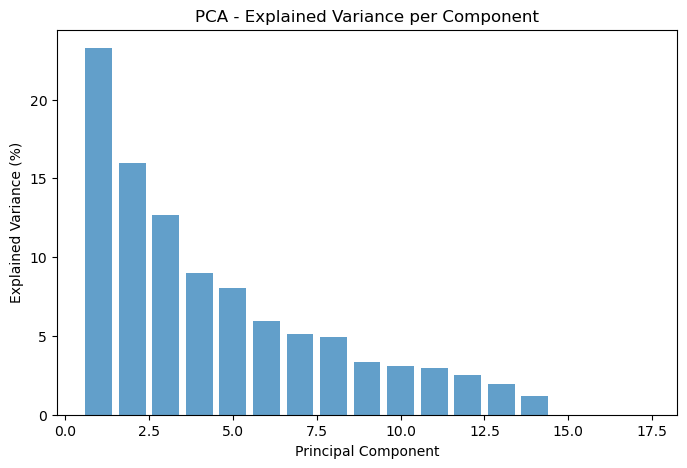

📈 Cumulative Explained Variance: [0.23266928 0.39210485 0.51855779 0.60829829 0.68870922 0.74823069
 0.79961926 0.8491637  0.88270932 0.91385815 0.94323893 0.9685566
 0.98815869 1.         1.         1.         1.        ]
✅ Optimal k value for PCA (90% variance explained): 10


In [223]:
# Perform PCA
pca = PCA(n_components=17)  # Choose number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print Explained Variance for each component
print("📊 Explained Variance Ratio:", explained_variance)

# Plot Explained Variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100, alpha=0.7, align='center')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("PCA - Explained Variance per Component")
plt.show()

# Print cumulative explained variance
print("📈 Cumulative Explained Variance:", cumulative_variance)

# Find the optimal k value where at least 95% variance is explained
optimal_k = np.argmax(cumulative_variance >= 0.90) + 1  # Adding 1 because index starts at 0

# Print the optimal k value
print(f"✅ Optimal k value for PCA (90% variance explained): {optimal_k}")

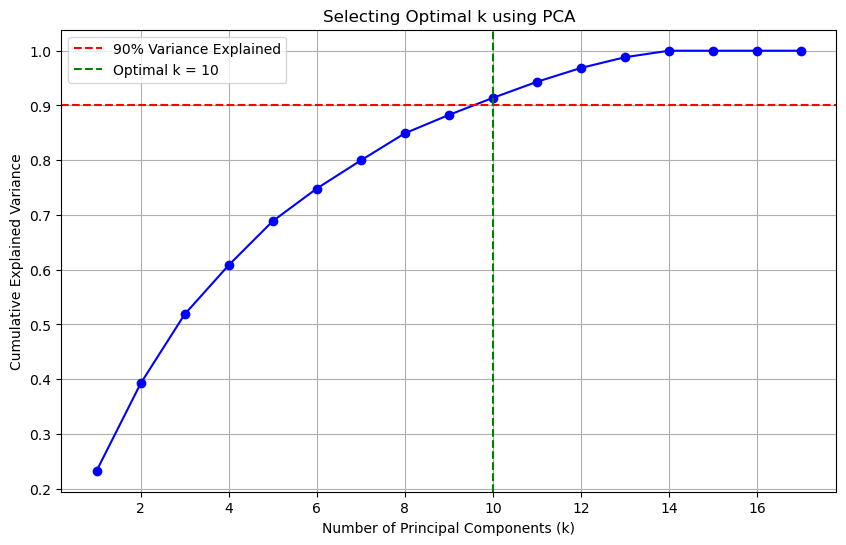

In [225]:
# Plot the explained variance to help select the optimal k value
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Selecting Optimal k using PCA")
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Explained")
plt.axvline(x=optimal_k, color='g', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.legend()
plt.show()


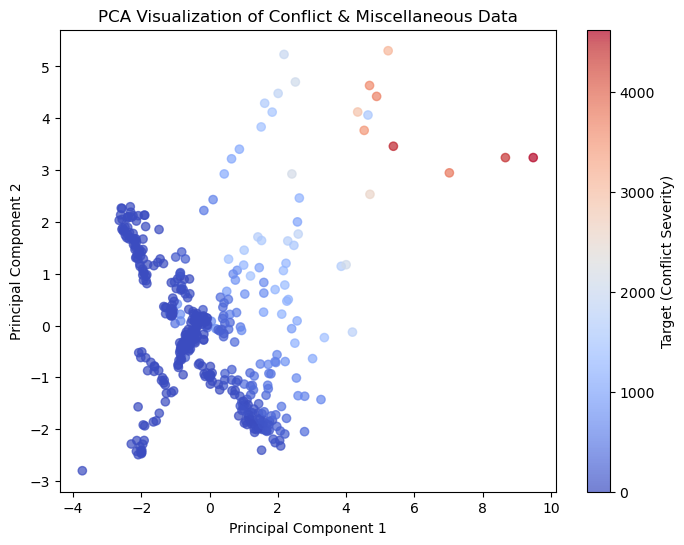

In [281]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Conflict & Miscellaneous Data")
plt.colorbar(label="Target (Conflict Severity)")
plt.show()


Conclusion: To get an optimal PCA, we need 10 features. 

In [229]:
# Models
models = {
    "OLS": None, #Placeholder for OLS since it's trained differently
    "LASSO": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train & Evaluate Models
results = {}

# Train OLS separately
X_train_ols = sm.add_constant(X_train)  # Add intercept
X_test_ols = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_ols).fit()
ols_predictions = ols_model.predict(X_test_ols)
ols_rmse = np.sqrt(mean_squared_error(y_test, ols_predictions))

# Store OLS results
results["OLS"] = {"model": ols_model, "predictions": ols_predictions, "rmse": ols_rmse}
models["OLS"] = ols_model  # Add trained OLS model to dictionary

# Train & Evaluate sklearn-based models
for name, model in models.items():
    if name == "OLS":
        continue  # OLS is already trained separately

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    results[name] = {"model": model, "predictions": predictions, "rmse": rmse}

# Print RMSE Scores for All Models
for name, result in results.items():
    print(f"✅ {name} RMSE: {result['rmse']:.2f}")


✅ OLS RMSE: 61.97
✅ LASSO RMSE: 61.90
✅ Ridge RMSE: 61.93
✅ Random Forest RMSE: 64.99
✅ Gradient Boosting RMSE: 93.71


## Random Forest Plot

Index(['crop_yield', 'food_insecurity', 'GDP', 'Inflation', 'Unemployment',
       'median_income', 'energy_usage', 'freshwater_withdrawal', 'Battles',
       'Armed clashes', 'Shelling', 'Remote violence',
       'Violence against civilians', 'Riots', 'Protests',
       'Average Temperature (°C)', 'Average Precipitation (mm)'],
      dtype='object')


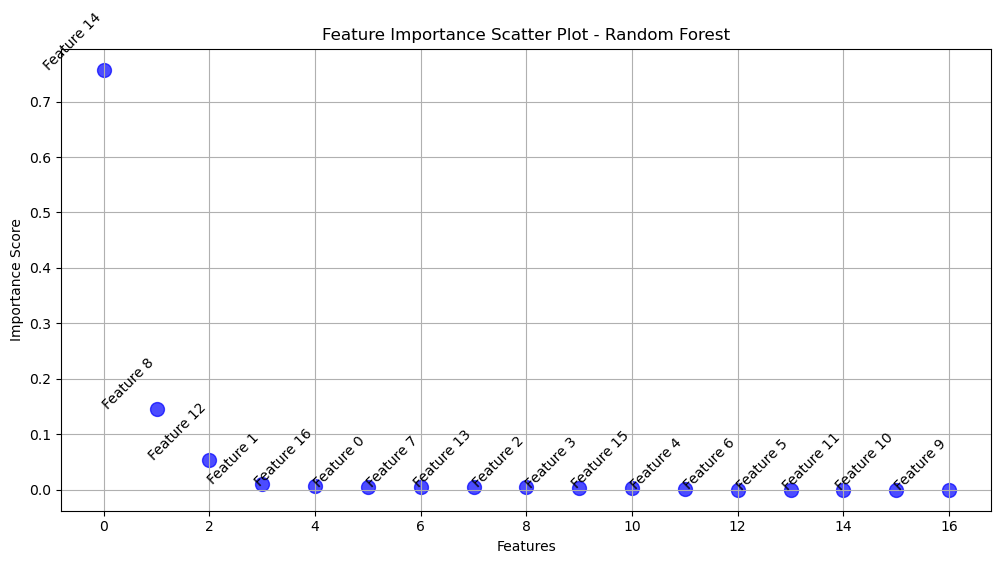

In [263]:
feature_names = X.columns  # Assuming X is the original DataFrame before scaling
print(feature_names)

importances = rf.feature_importances_
feature_names = [f"Feature {i}" for i in range(X_scaled.shape[1])]

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(importances)), importances[sorted_indices], color="blue", s=100, alpha=0.7)

# Annotate each point with feature names
for i, txt in enumerate(np.array(feature_names)[sorted_indices]):
    plt.annotate(txt, (i, importances[sorted_indices][i]), fontsize=10, rotation=45, ha="right")

plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance Scatter Plot - Random Forest")
plt.grid(True)
plt.show()


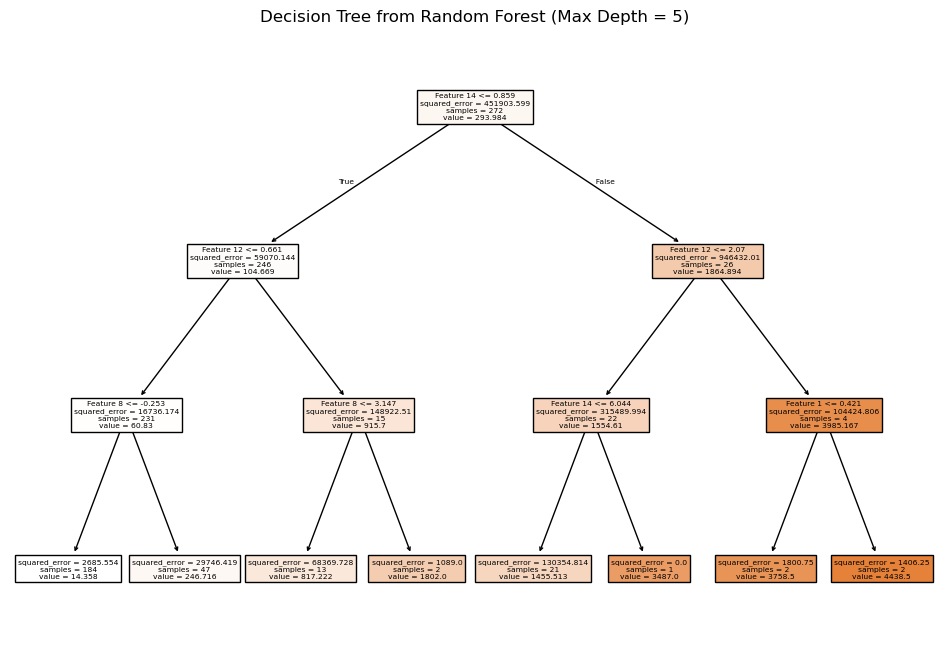

In [267]:
# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_scaled, y)

# Extract a single decision tree from the trained Random Forest model
single_tree = rf.estimators_[0]

# Plot the decision tree structure from Random Forest
plt.figure(figsize=(12, 8))
plot_tree(single_tree, feature_names=[f"Feature {i}" for i in range(X_scaled.shape[1])], filled=True, max_depth=3)
plt.title("Decision Tree from Random Forest (Max Depth = 5)")
plt.show()


## Pre-set Model Performance (Without Cross Validation)

total_conflicts
0    229
2    148
1     60
Name: count, dtype: int64


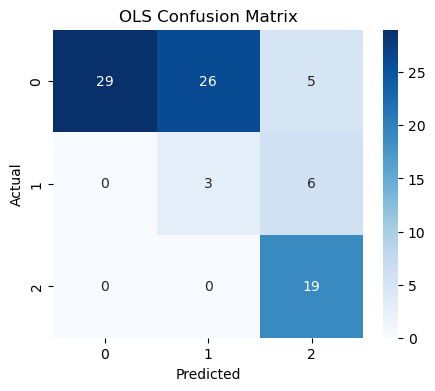

🔹 Classification Report for OLS 🔹
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        60
           1       0.10      0.33      0.16         9
           2       0.63      1.00      0.78        19

    accuracy                           0.58        88
   macro avg       0.58      0.61      0.53        88
weighted avg       0.83      0.58      0.63        88



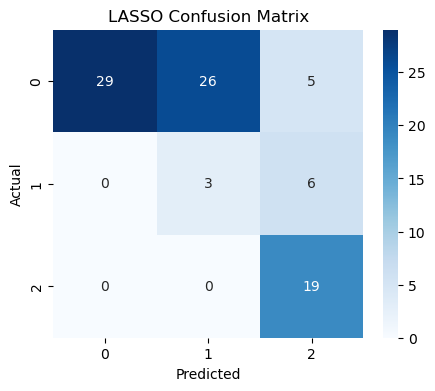

🔹 Classification Report for LASSO 🔹
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        60
           1       0.10      0.33      0.16         9
           2       0.63      1.00      0.78        19

    accuracy                           0.58        88
   macro avg       0.58      0.61      0.53        88
weighted avg       0.83      0.58      0.63        88



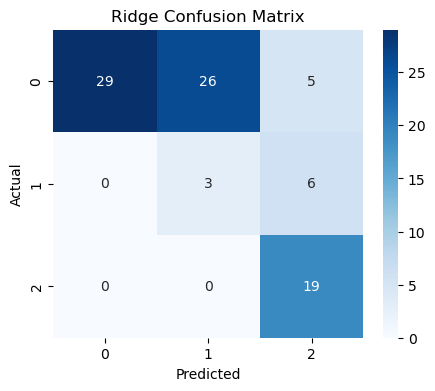

🔹 Classification Report for Ridge 🔹
              precision    recall  f1-score   support

           0       1.00      0.48      0.65        60
           1       0.10      0.33      0.16         9
           2       0.63      1.00      0.78        19

    accuracy                           0.58        88
   macro avg       0.58      0.61      0.53        88
weighted avg       0.83      0.58      0.63        88

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


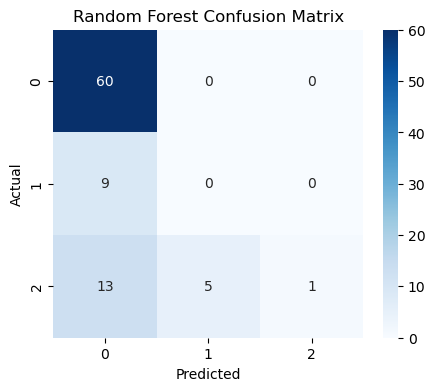

🔹 Classification Report for Random Forest 🔹
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        60
           1       0.00      0.00      0.00         9
           2       1.00      0.05      0.10        19

    accuracy                           0.69        88
   macro avg       0.58      0.35      0.32        88
weighted avg       0.71      0.69      0.60        88



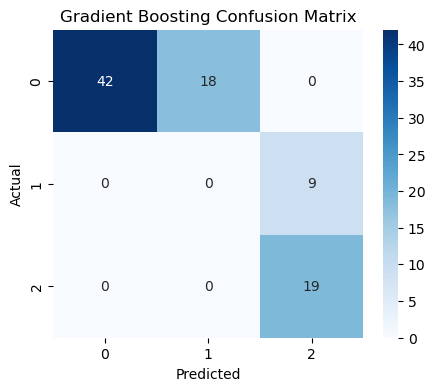

🔹 Classification Report for Gradient Boosting 🔹
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        60
           1       0.00      0.00      0.00         9
           2       0.68      1.00      0.81        19

    accuracy                           0.69        88
   macro avg       0.56      0.57      0.54        88
weighted avg       0.83      0.69      0.74        88

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


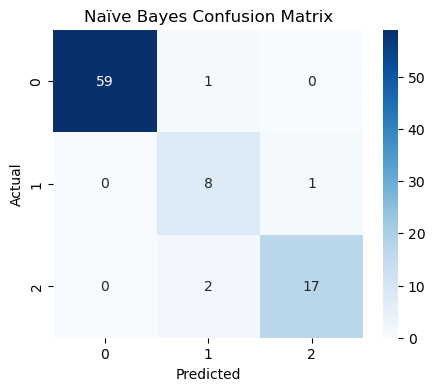

🔹 Classification Report for Naïve Bayes 🔹
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.73      0.89      0.80         9
           2       0.94      0.89      0.92        19

    accuracy                           0.95        88
   macro avg       0.89      0.92      0.90        88
weighted avg       0.96      0.95      0.96        88



In [346]:
# Add small offset to ensure bins are unique
bins = [y.min(), y.quantile(0.33) + 1e-6, y.quantile(0.66) + 1e-6, y.max()]
y_class = pd.cut(y, bins=bins, labels=labels, include_lowest=True)

print(y_class.value_counts())


# Train Naïve Bayes Classifier
nb = GaussianNB()
nb.fit(X_train, y_class.loc[y_train.index])
nb_pred = nb.predict(X_test)

# Save Naïve Bayes results
results["Naïve Bayes"] = {"model": nb, "predictions": nb_pred}

def categorize_predictions(predictions):
    """
    Converts continuous predictions into categorical bins (Low, Medium, High).
    Uses `qcut()` if possible, otherwise falls back to `cut()`.
    """
    unique_values = len(np.unique(predictions))

    # If there are fewer than 3 unique values, force discrete categories
    if unique_values < 3:
        print("⚠️ Not enough unique values for qcut(). Using equal-width binning instead.")
        return pd.cut(predictions, bins=3, labels=[0, 1, 2], include_lowest=True)

    try:
        return pd.qcut(predictions, q=3, labels=[0, 1, 2], duplicates="drop")
    except ValueError:
        print("⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.")
        bins = np.linspace(predictions.min(), predictions.max(), num=4)  # 3 bins
        return pd.cut(predictions, bins=bins, labels=[0, 1, 2], include_lowest=True)


for name, result in results.items():
    pred_categories = categorize_predictions(result["predictions"])
    actual_categories = y_class.loc[y_test.index]

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(actual_categories, pred_categories)

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Print Classification Report
    print(f"🔹 Classification Report for {name} 🔹")
    print(classification_report(actual_categories, pred_categories))


⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


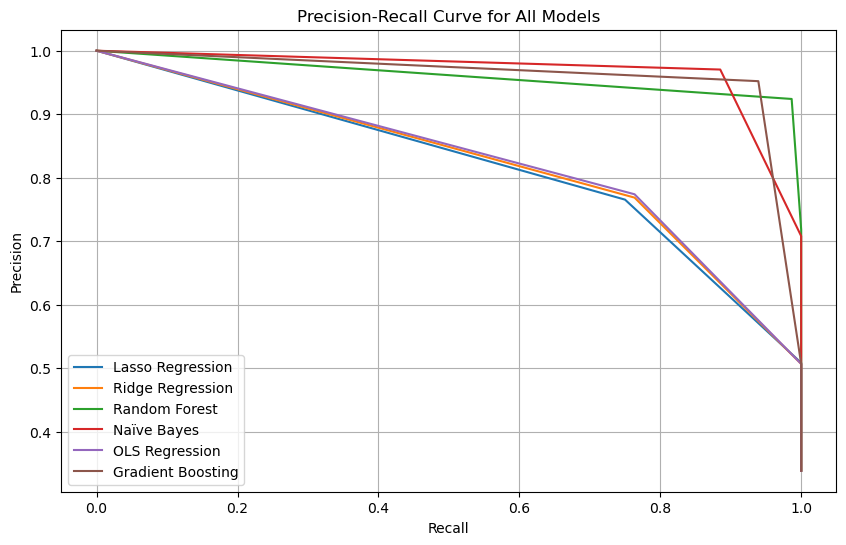

In [348]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall Curve for each model
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in kf.split(X_scaled, y_class):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_class.iloc[train_index], y_class.iloc[test_index]

        if name == "OLS Regression":
            # OLS Regression (Handled Separately)
            X_train_ols = sm.add_constant(X_train_cv)  # Add intercept
            X_test_ols = sm.add_constant(X_test_cv)

            ols_model = sm.OLS(y_train_cv, X_train_ols).fit()
            y_pred_cv = ols_model.predict(X_test_ols)

        else:
            # Train model
            model.fit(X_train_cv, y_train_cv)

            # Predict on test set
            y_pred_cv = model.predict(X_test_cv)

        # Convert predictions into categorical labels
        y_pred_cv_categorized = categorize_predictions(y_pred_cv)

        y_true_all.extend(y_test_cv)
        y_pred_all.extend(y_pred_cv_categorized)

    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(pd.Series(y_true_all).astype(int), pd.Series(y_pred_all).astype(int), pos_label=2)
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for All Models")
plt.legend()
plt.grid(True)
plt.show()



5 K-Fold Cross Validation

In [351]:
# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold CV

# Add OLS and Gradient Boosting to the models list
models["OLS Regression"] = "OLS"  # Placeholder for OLS since it requires a different approach
models["Gradient Boosting"] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Store cross-validation results
cv_results = {}

# Perform Stratified K-Fold Cross-Validation for each model
for name, model in models.items():
    scores = []

    for train_index, test_index in kf.split(X_scaled, y_class):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_class.iloc[train_index], y_class.iloc[test_index]

        if name == "OLS Regression":
            # OLS Regression requires a different approach
            X_train_ols = sm.add_constant(X_train_cv)  # Add intercept
            X_test_ols = sm.add_constant(X_test_cv)

            ols_model = sm.OLS(y_train_cv, X_train_ols).fit()
            y_pred_cv = ols_model.predict(X_test_ols)

            # Convert continuous OLS predictions into categorical labels
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

            # Compute R² score for regression
            score = r2_score(y_test_cv, y_pred_cv)

        else:
            # Train the model
            model.fit(X_train_cv, y_train_cv)

            # Predict on test set
            y_pred_cv = model.predict(X_test_cv)

            # Convert predictions to categorical labels for confusion matrix
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

            # Choose correct metric based on model type
            if name == "Naïve Bayes":
                score = accuracy_score(y_test_cv, y_pred_cv_categorized)
            else:
                score = r2_score(y_test_cv, y_pred_cv)

        scores.append(score)

    cv_results[name] = scores
    print(f"📊 {name} Cross-Validation Scores: {scores}")
    print(f"✅ Mean CV Score: {np.mean(scores):.4f}\n")




📊 Lasso Regression Cross-Validation Scores: [0.650038426659616, 0.5837263414105973, 0.6238035877679363, 0.6439142829061797, 0.6525082857105619]
✅ Mean CV Score: 0.6308

📊 Ridge Regression Cross-Validation Scores: [0.69018400072708, 0.6266248884454015, 0.672874224916669, 0.6712273219263114, 0.6923863131723781]
✅ Mean CV Score: 0.6707

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
📊 Random Forest Cross-Validation Scores: [0.9702142287990894, 0.9637491670790038, 0.9648265480107688, 0.9553315763707572, 0.9825670254699818]
✅ Mean CV Score: 0.9673

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate b

## Confusion Matrix for 5 K-Fold Cross Validation

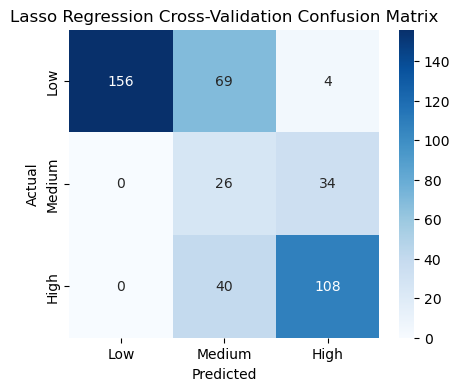

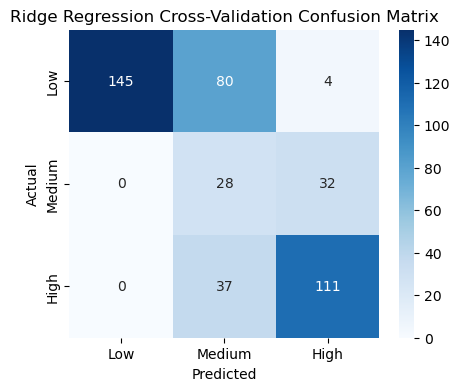

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


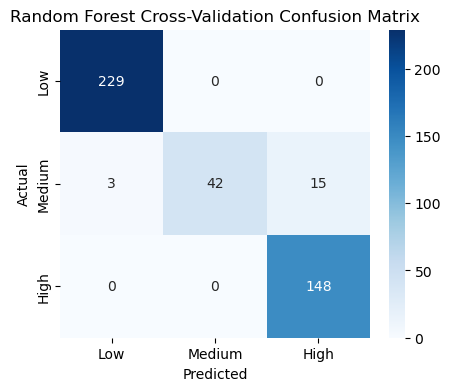

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


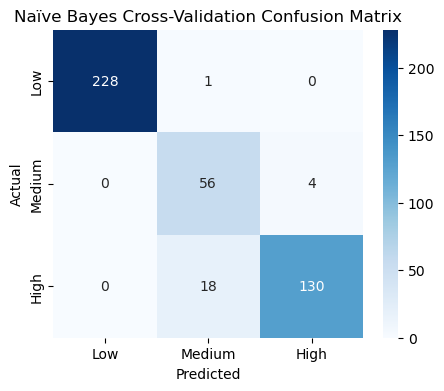

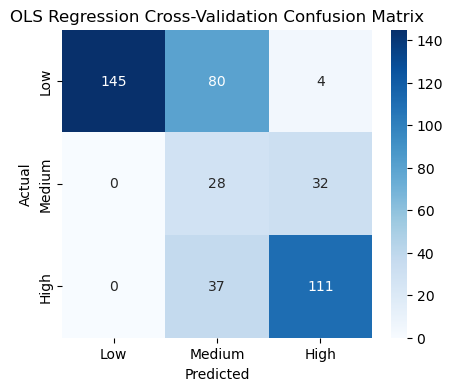

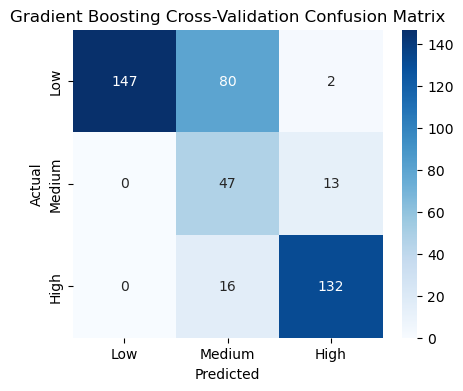

In [354]:
# Add OLS and Gradient Boosting to the models dictionary
models["OLS Regression"] = "OLS"  # Placeholder since OLS requires a different approach
models["Gradient Boosting"] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Store confusion matrices for each model
conf_matrices = {}

# Perform  K-Fold Cross-Validation and generate confusion matrices
for name, model in models.items():
    conf_matrix_total = np.zeros((3, 3))  # Initialize 3x3 confusion matrix

    for train_index, test_index in kf.split(X_scaled, y_class):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_class.iloc[train_index], y_class.iloc[test_index]

        if name == "OLS Regression":
            # OLS Regression (Handled Separately)
            X_train_ols = sm.add_constant(X_train_cv)  # Add intercept
            X_test_ols = sm.add_constant(X_test_cv)

            ols_model = sm.OLS(y_train_cv, X_train_ols).fit()
            y_pred_cv = ols_model.predict(X_test_ols)

            # Convert continuous OLS predictions into categorical labels
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

        else:
            # Train model
            model.fit(X_train_cv, y_train_cv)

            # Predict on test set
            y_pred_cv = model.predict(X_test_cv)

            # Convert predictions to categorical labels
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_test_cv, y_pred_cv_categorized, labels=[0, 1, 2])

        # Sum confusion matrices across folds
        conf_matrix_total += conf_matrix

    # Convert float values to integers
    conf_matrix_total = conf_matrix_total.astype(int)

    # Store final confusion matrix
    conf_matrices[name] = conf_matrix_total

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_total, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Cross-Validation Confusion Matrix")
    plt.show()



⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


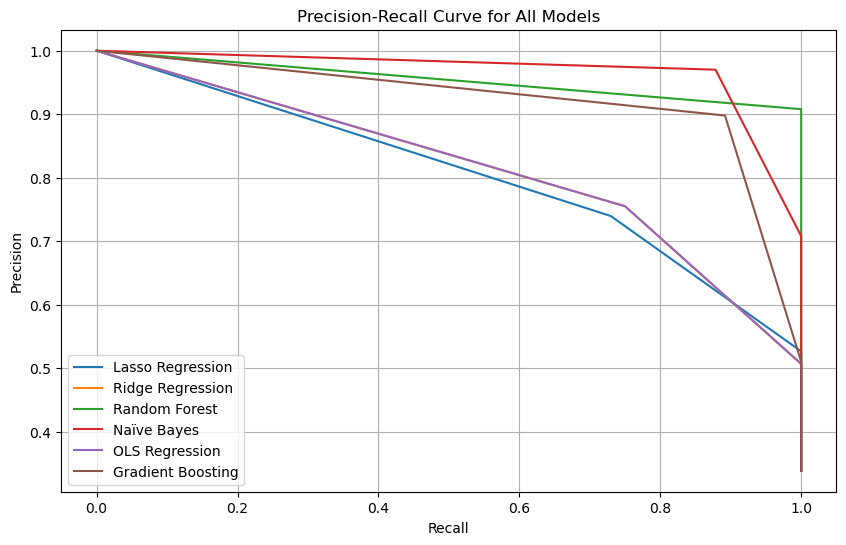

In [356]:
# Plot Precision-Recall Curve for each model
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in kf.split(X_scaled, y_class):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_class.iloc[train_index], y_class.iloc[test_index]

        if name == "OLS Regression":
            # OLS Regression (Handled Separately)
            X_train_ols = sm.add_constant(X_train_cv)  # Add intercept
            X_test_ols = sm.add_constant(X_test_cv)

            ols_model = sm.OLS(y_train_cv, X_train_ols).fit()
            y_pred_cv = ols_model.predict(X_test_ols)

        else:
            # Train model
            model.fit(X_train_cv, y_train_cv)

            # Predict on test set
            y_pred_cv = model.predict(X_test_cv)

        # Convert predictions into categorical labels
        y_pred_cv_categorized = categorize_predictions(y_pred_cv)

        y_true_all.extend(y_test_cv)
        y_pred_all.extend(y_pred_cv_categorized)

    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(pd.Series(y_true_all).astype(int), pd.Series(y_pred_all).astype(int), pos_label=2)
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for All Models")
plt.legend()
plt.grid(True)
plt.show()


## Stratified 5 K-Folds Cross Validation for Possible Imbalance Dataset

In [359]:
# Define Stratified K-Fold Cross-Validation (Ensures class balance in folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Add OLS and Gradient Boosting to the models list
models["OLS Regression"] = "OLS"  # Placeholder for OLS since it requires a different approach
models["Gradient Boosting"] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Store cross-validation results
cv_results = {}

# Perform Stratified K-Fold Cross-Validation for each model
for name, model in models.items():
    scores = []

    for train_index, test_index in kf.split(X_scaled, y_class):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_class.iloc[train_index], y_class.iloc[test_index]

        if name == "OLS Regression":
            # OLS Regression requires a different approach
            X_train_ols = sm.add_constant(X_train_cv)  # Add intercept
            X_test_ols = sm.add_constant(X_test_cv)

            ols_model = sm.OLS(y_train_cv, X_train_ols).fit()
            y_pred_cv = ols_model.predict(X_test_ols)

            # Convert continuous OLS predictions into categorical labels
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

            # Compute R² score for regression
            score = r2_score(y_test_cv, y_pred_cv)

        else:
            # Train the model
            model.fit(X_train_cv, y_train_cv)

            # Predict on test set
            y_pred_cv = model.predict(X_test_cv)

            # Convert predictions to categorical labels for confusion matrix
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

            # Choose correct metric based on model type
            if name == "Naïve Bayes":
                score = accuracy_score(y_test_cv, y_pred_cv_categorized)
            else:
                score = r2_score(y_test_cv, y_pred_cv)

        scores.append(score)

    cv_results[name] = scores
    print(f"📊 {name} Cross-Validation Scores: {scores}")
    print(f"✅ Mean CV Score: {np.mean(scores):.4f}\n")


📊 Lasso Regression Cross-Validation Scores: [0.6740226424914708, 0.6011040852719479, 0.583490320009403, 0.6313190878549213, 0.731681234295555]
✅ Mean CV Score: 0.6443

📊 Ridge Regression Cross-Validation Scores: [0.6787448519365546, 0.5804368036715353, 0.6104198953243037, 0.7077255645696919, 0.7606079176141738]
✅ Mean CV Score: 0.6676

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
📊 Random Forest Cross-Validation Scores: [0.981914303482587, 0.9663514925373135, 0.9685287684413085, 0.9656185375240539, 0.966329619047619]
✅ Mean CV Score: 0.9697

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate b

Confusion Matrix for Stratified K-Folds

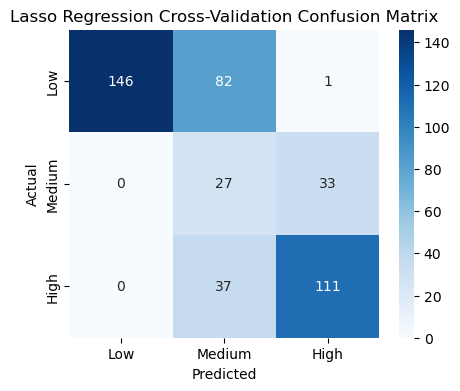

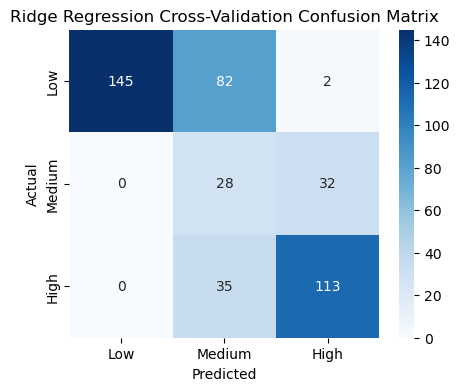

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


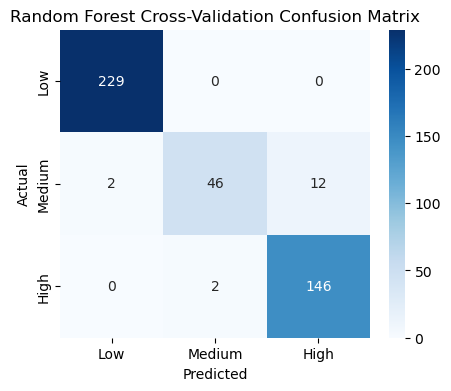

⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


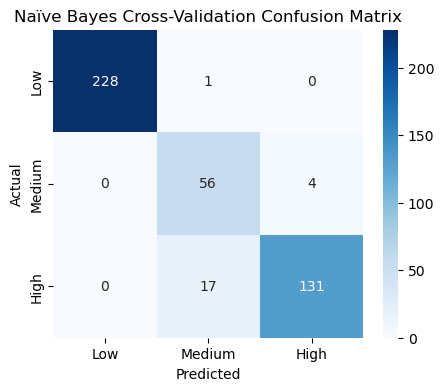

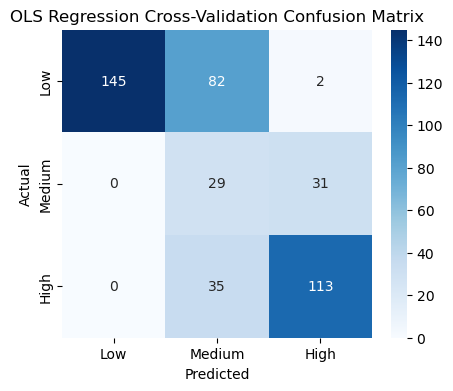

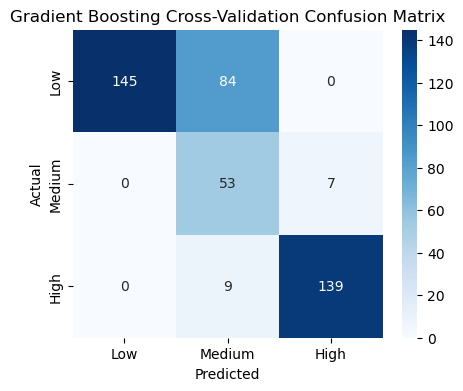

In [362]:
# Add OLS and Gradient Boosting to the models dictionary
models["OLS Regression"] = "OLS"  # Placeholder since OLS requires a different approach
models["Gradient Boosting"] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Store confusion matrices for each model
conf_matrices = {}

# Perform Stratified K-Fold Cross-Validation and generate confusion matrices
for name, model in models.items():
    conf_matrix_total = np.zeros((3, 3))  # Initialize 3x3 confusion matrix

    for train_index, test_index in kf.split(X_scaled, y_class):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_class.iloc[train_index], y_class.iloc[test_index]

        if name == "OLS Regression":
            # OLS Regression (Handled Separately)
            X_train_ols = sm.add_constant(X_train_cv)  # Add intercept
            X_test_ols = sm.add_constant(X_test_cv)

            ols_model = sm.OLS(y_train_cv, X_train_ols).fit()
            y_pred_cv = ols_model.predict(X_test_ols)

            # Convert continuous OLS predictions into categorical labels
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

        else:
            # Train model
            model.fit(X_train_cv, y_train_cv)

            # Predict on test set
            y_pred_cv = model.predict(X_test_cv)

            # Convert predictions to categorical labels
            y_pred_cv_categorized = categorize_predictions(y_pred_cv)

        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_test_cv, y_pred_cv_categorized, labels=[0, 1, 2])

        # Sum confusion matrices across folds
        conf_matrix_total += conf_matrix

    # Convert float values to integers
    conf_matrix_total = conf_matrix_total.astype(int)

    # Store final confusion matrix
    conf_matrices[name] = conf_matrix_total

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_total, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} Cross-Validation Confusion Matrix")
    plt.show()




⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.
⚠️ qcut() failed due to duplicate bin edges. Using cut() instead.


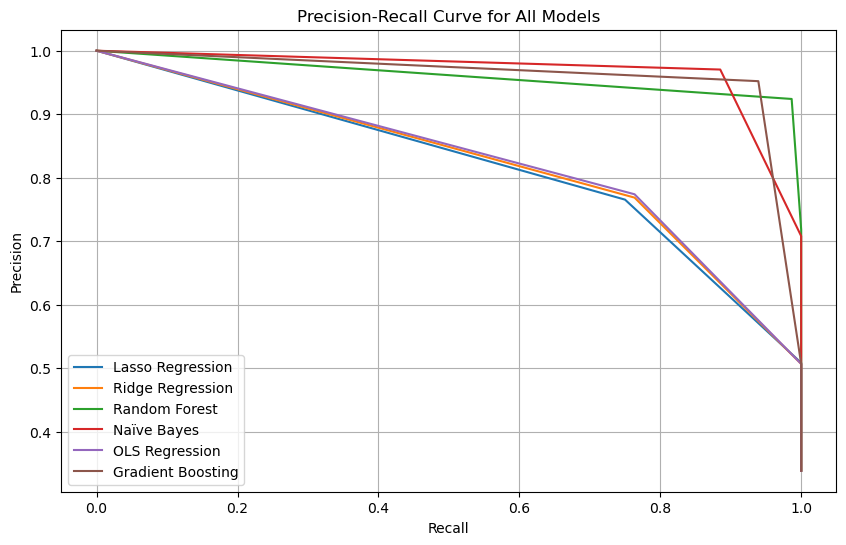

In [364]:
# Plot Precision-Recall Curve for each model
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in kf.split(X_scaled, y_class):
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_class.iloc[train_index], y_class.iloc[test_index]

        if name == "OLS Regression":
            # OLS Regression (Handled Separately)
            X_train_ols = sm.add_constant(X_train_cv)  # Add intercept
            X_test_ols = sm.add_constant(X_test_cv)

            ols_model = sm.OLS(y_train_cv, X_train_ols).fit()
            y_pred_cv = ols_model.predict(X_test_ols)

        else:
            # Train model
            model.fit(X_train_cv, y_train_cv)

            # Predict on test set
            y_pred_cv = model.predict(X_test_cv)

        # Convert predictions into categorical labels
        y_pred_cv_categorized = categorize_predictions(y_pred_cv)

        y_true_all.extend(y_test_cv)
        y_pred_all.extend(y_pred_cv_categorized)

    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(pd.Series(y_true_all).astype(int), pd.Series(y_pred_all).astype(int), pos_label=2)
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for All Models")
plt.legend()
plt.grid(True)
plt.show()


Analysis: Based on the RMSE of our models and mean Cross Validation value (both normal and stratified), the gradient-boosting random tree model is our best machine learning model. It maintained a high precision throughout before converging with the other trends. The second best model was the Naïve Bayes. My main suspicious is that the model is higly imbalanced, and I will have to add more features later.

## Conclusion

In conclusion, feature 14 or protests was the root of our decision tree and random forest. PCA model indicated that the optimal k-score was 10 principal components that accounted for 90% of the variance. From the cross-validation, our dataset is imbalanced, which is most likely caused by the missing values from the WorldBank API. In the future for the final project, I will add more geographical elements like magnetic waves and social ones like human trafficking, level of education, population by age and sex, and weapons manufacturing. I also plan on taking away some of the ACLED elements (if not all) so the data set will be more balanced. Finally, I will focus more on binary classifiers and fine-tuning hyperparameters (i.e. is the country next to a body of water). 